In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize=(5,5))

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.1.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


In [30]:
%%HTML
<img src="img/anndata.svg" style="height:500px">

AnnData.X stores the count matrix<br>
AnnData.obs stores metadata about the observations (cells)<br>
AnnData.var stores metadata about the variables (genes)<br>
AnnData.uns stores any additional, unstructured information we decide to attach later

In [4]:
adata = sc.read_10x_h5('vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.h5') # the directory with the `.h5` file

reading vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata

AnnData object with n_obs × n_vars = 7231 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
adata.var_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


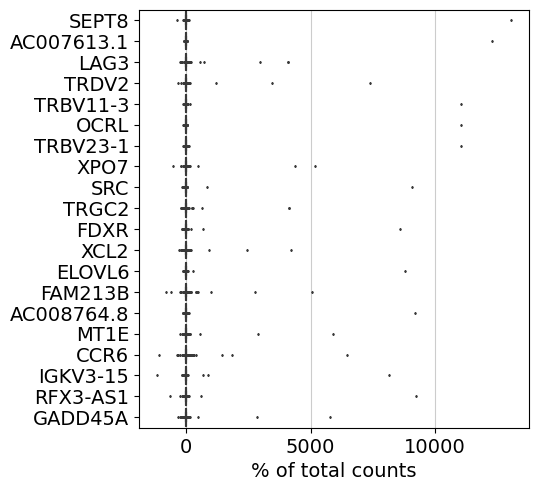

In [31]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 10 cells that have less than 200 genes expressed
filtered out 16221 genes that are detected in less than 3 cells


In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

In [12]:
adata

AnnData object with n_obs × n_vars = 7221 × 17317
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

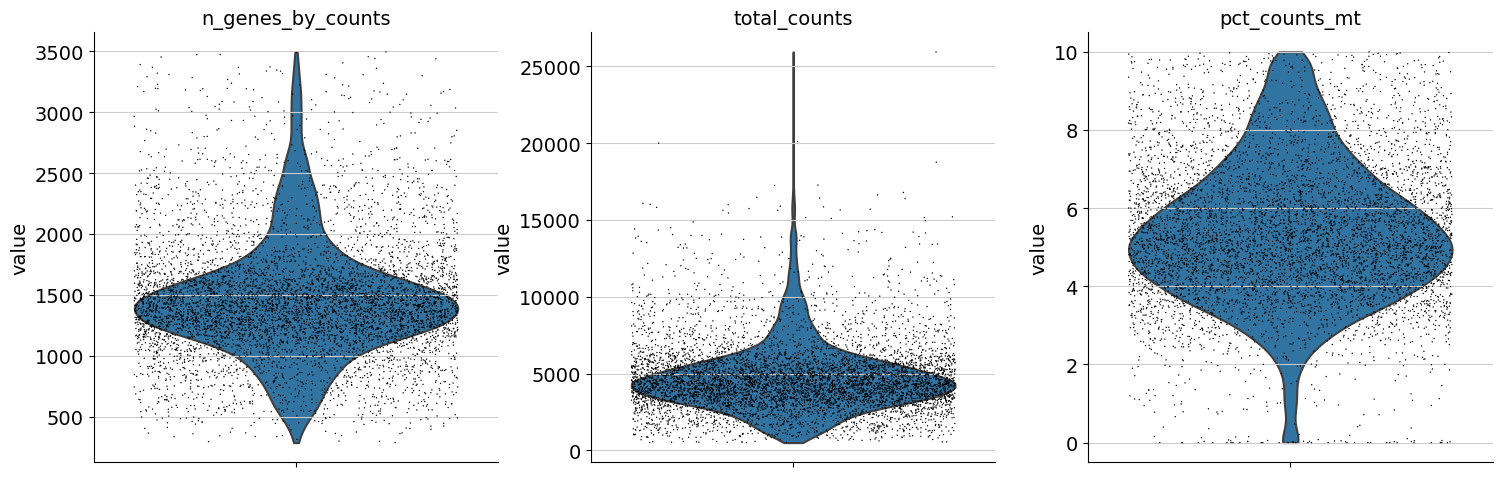

In [32]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

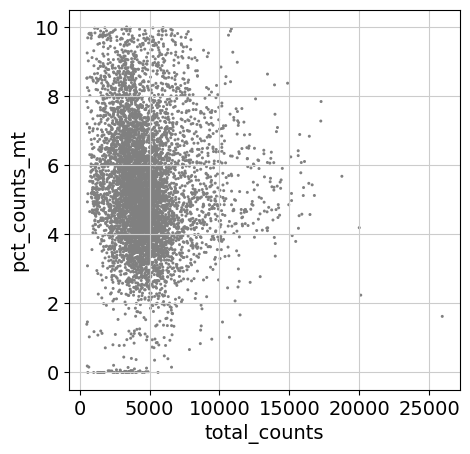

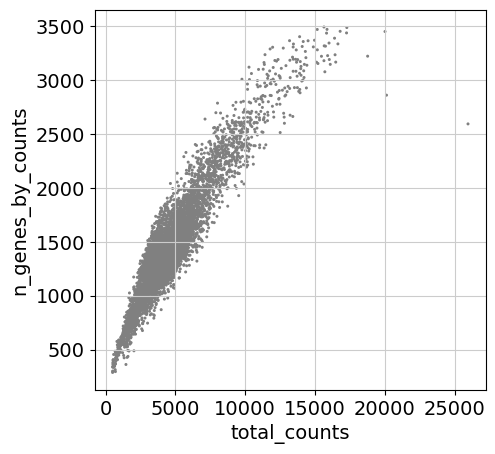

In [37]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 3500, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

In [16]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [17]:
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


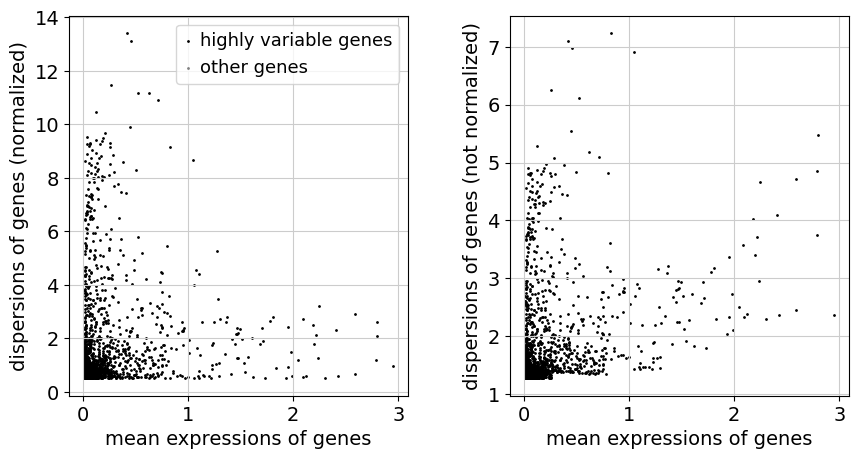

In [38]:
sc.pl.highly_variable_genes(adata)

In [20]:
adata

AnnData object with n_obs × n_vars = 6430 × 17317
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [21]:
adata.raw = adata

In [22]:
adata = adata[:, adata.var.highly_variable]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 6430 × 1475
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [24]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:15)


In [25]:
sc.pp.scale(adata, max_value=10)

In [26]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


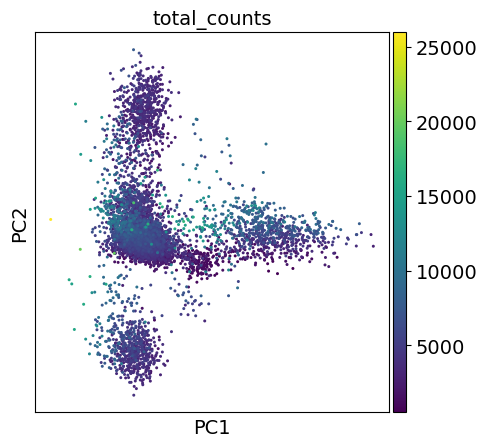

In [39]:
sc.pl.pca(adata, color='total_counts')

In [40]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [41]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


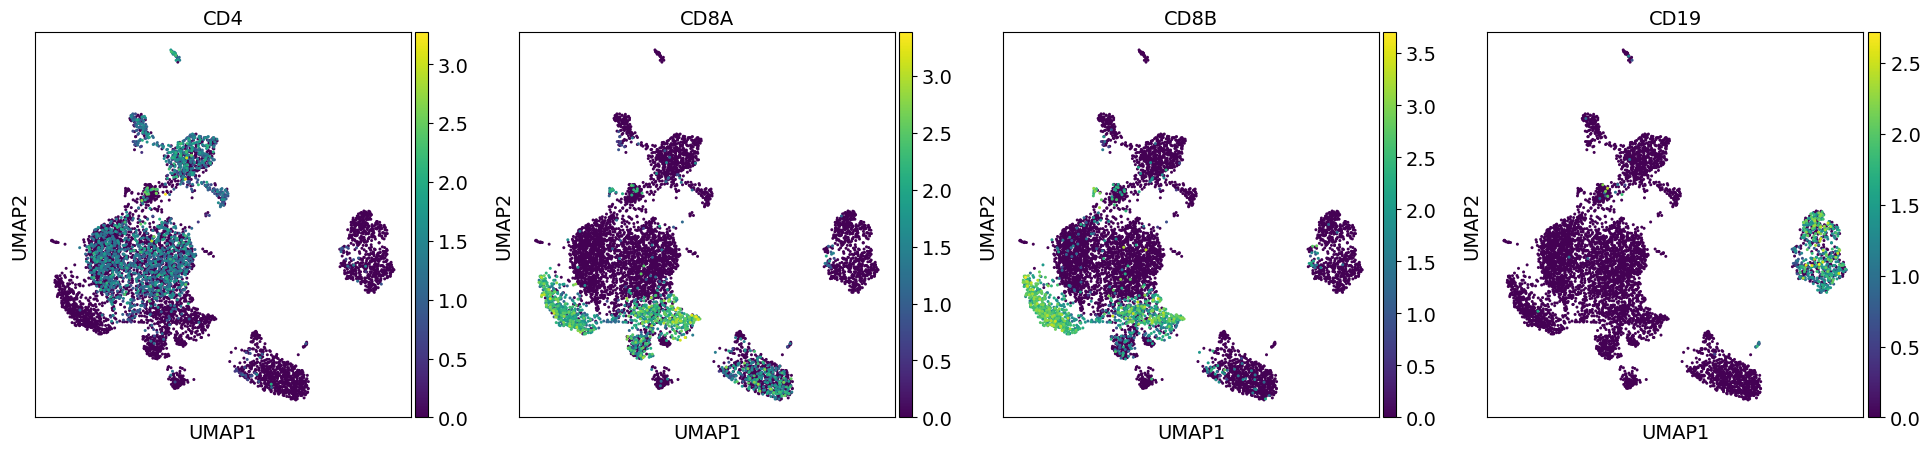

In [42]:
sc.pl.umap(adata, color=['CD4', 'CD8A', 'CD8B', 'CD19'])

In [43]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


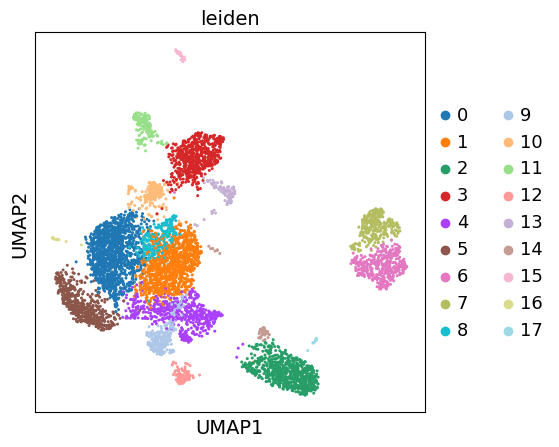

In [44]:
sc.pl.umap(adata, color=['leiden'])

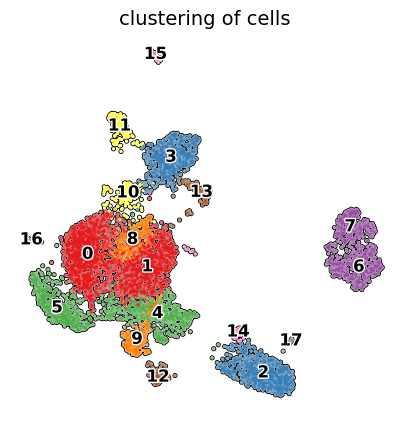

In [59]:
sc.pl.umap(adata, color=['leiden'], add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1')

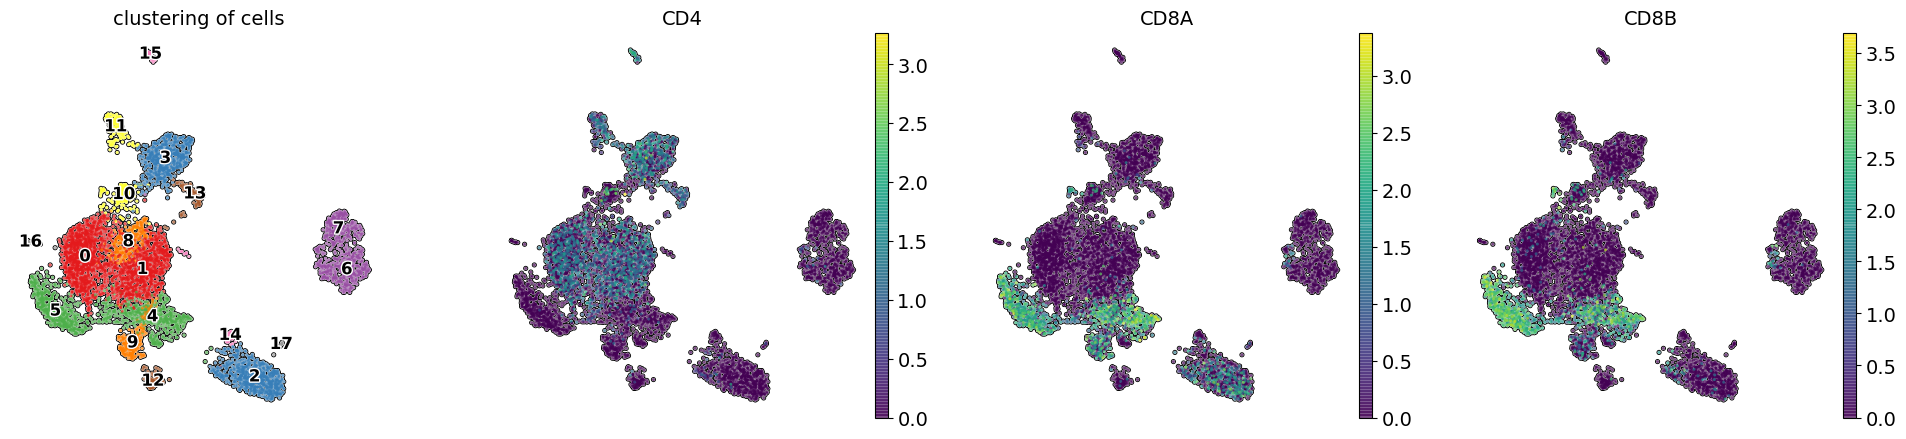

In [60]:
sc.pl.umap(adata, color=['leiden', 'CD4', 'CD8A', 'CD8B'], add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


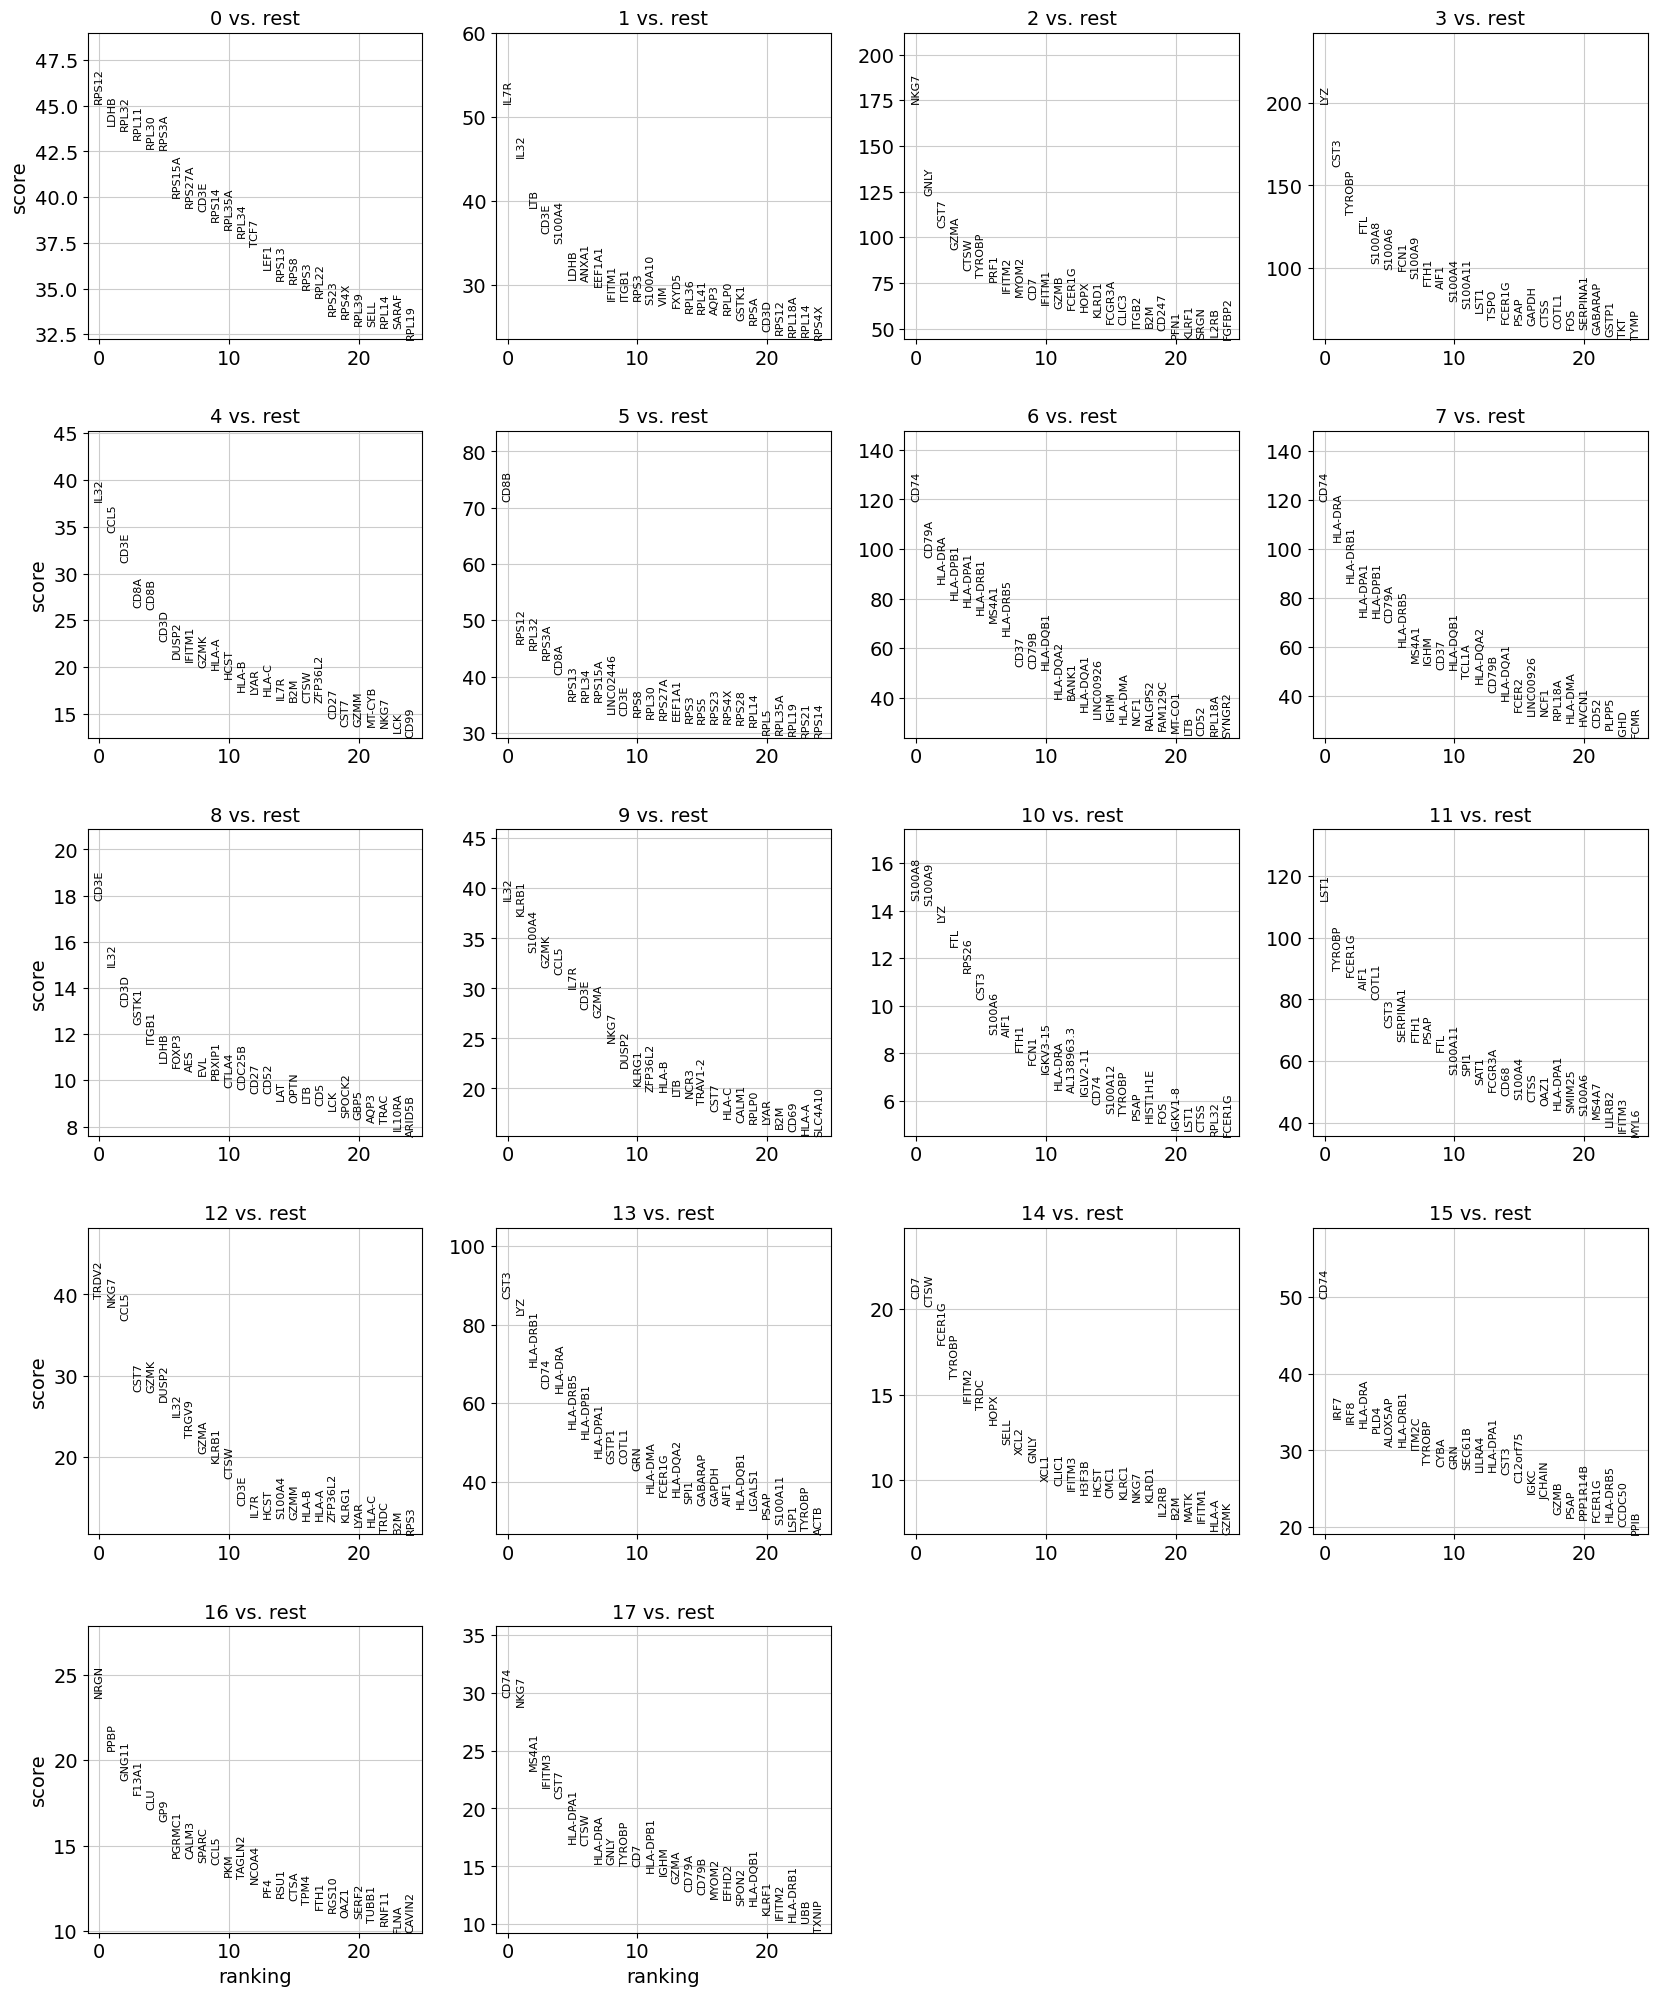

In [45]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [46]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1     2       3     4      5         6         7      8  \
0  RPS12    IL7R  NKG7     LYZ  IL32   CD8B      CD74      CD74   CD3E   
1   LDHB    IL32  GNLY    CST3  CCL5  RPS12     CD79A   HLA-DRA   IL32   
2  RPL32     LTB  CST7  TYROBP  CD3E  RPL32   HLA-DRA  HLA-DRB1   CD3D   
3  RPL11    CD3E  GZMA     FTL  CD8A  RPS3A  HLA-DPB1  HLA-DPA1  GSTK1   
4  RPL30  S100A4  CTSW  S100A8  CD8B   CD8A  HLA-DPA1  HLA-DPB1  ITGB1   

        9      10      11     12        13      14       15     16      17  
0    IL32  S100A8    LST1  TRDV2      CST3     CD7     CD74   NRGN    CD74  
1   KLRB1  S100A9  TYROBP   NKG7       LYZ    CTSW     IRF7   PPBP    NKG7  
2  S100A4     LYZ  FCER1G   CCL5  HLA-DRB1  FCER1G     IRF8  GNG11   MS4A1  
3    GZMK     FTL    AIF1   CST7      CD74  TYROBP  HLA-DRA  F13A1  IFITM3  
4    CCL5   RPS26   COTL1   GZMK   HLA-DRA  IFITM2     PLD4    CLU    CST7

In [47]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n            1_p   2_n  2_p     3_n  3_p   4_n  \
0  RPS12   0.000000e+00    IL7R   0.000000e+00  NKG7  0.0     LYZ  0.0  IL32   
1   LDHB   0.000000e+00    IL32   0.000000e+00  GNLY  0.0    CST3  0.0  CCL5   
2  RPL32   0.000000e+00     LTB  3.941000e-265  CST7  0.0  TYROBP  0.0  CD3E   
3  RPL11   0.000000e+00    CD3E  2.833058e-247  GZMA  0.0     FTL  0.0  CD8A   
4  RPL30  1.379018e-317  S100A4  2.125846e-225  CTSW  0.0  S100A8  0.0  CD8B   

             4_p  ...      13_n           13_p    14_n          14_p     15_n  \
0  5.634487e-205  ...      CST3  4.746294e-108     CD7  6.125052e-25     CD74   
1  3.888802e-145  ...       LYZ  7.670539e-109    CTSW  3.361065e-24     IRF7   
2  3.813328e-156  ...  HLA-DRB1   2.227553e-92  FCER1G  1.073915e-22     IRF8   
3  5.524605e-101  ...      CD74   4.864343e-96  TYROBP  1.539764e-20  HLA-DRA   
4  3.152280e-100  ...   HLA-DRA   2.663863e-85  IFITM2  1.060882e-18     PLD4   

           15_p   16_n          16_p    17_n          17_p  
0  3.280784e-37   NRGN  1.868582e-11    CD74  3.522332e-11  
1  8.345053e-26   PPBP  1.002411e-10    NKG7  9.891584e-11  
2  1.615263e-25  GNG11  2.844950e-10   MS4A1  1.512178e-09  
3  1.827075e-27  F13A1  4.674207e-10  IFITM3  9.257594e-10  
4  5.654066e-25    CLU  8.527302e-10    CST7  2.979025e-09  

[5 rows x 36 columns]

In [50]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'CD4', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [61]:
marker_genes_dict = {'NK': ['GNLY', 'NKG7'],
                     'T-cell': ['CD3D'],
                     'B-cell': ['CD79A', 'MS4A1'],
                     'Monocytes': ['FCGR3A'],
                     'Dendritic': ['FCER1A']}

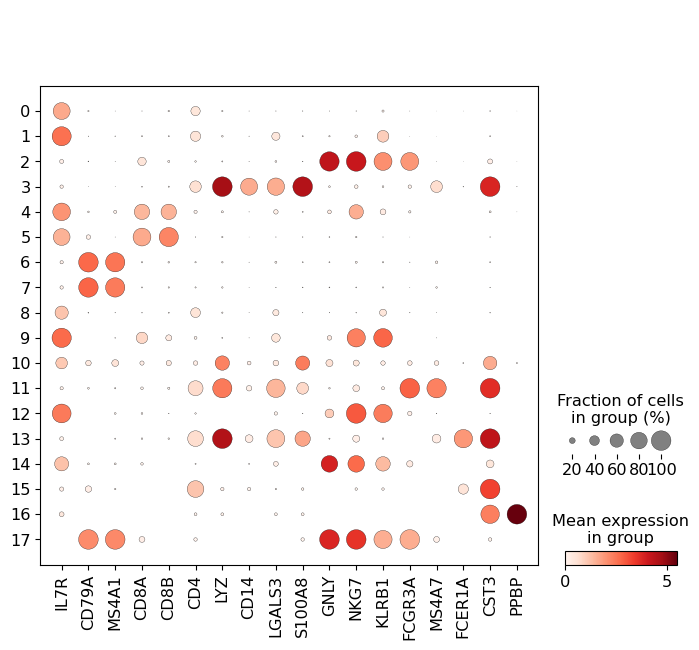

In [51]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

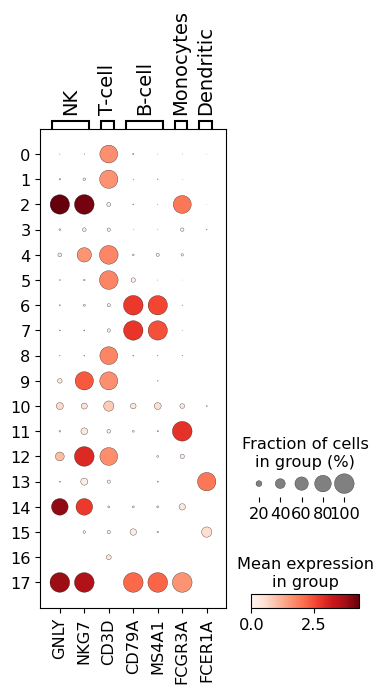

In [63]:
sc.pl.dotplot(adata, marker_genes_dict, 'leiden')

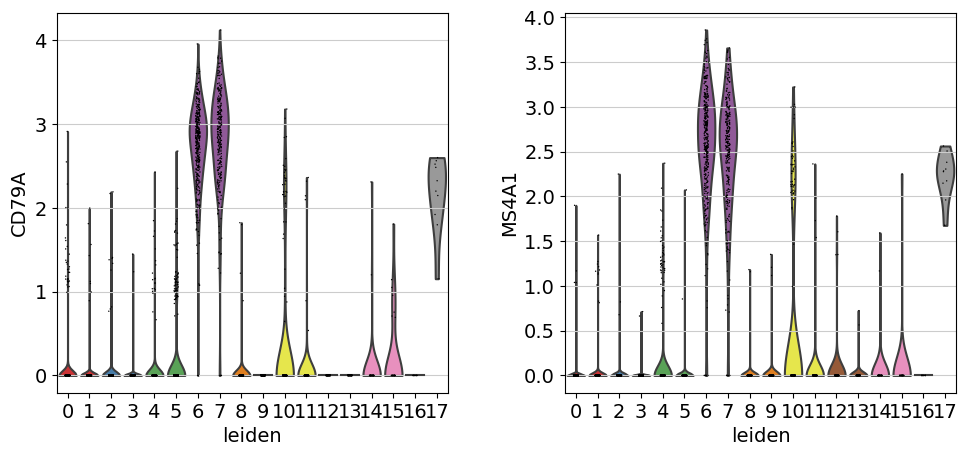

In [64]:
sc.pl.violin(adata, ['CD79A', 'MS4A1'], groupby='leiden' )

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


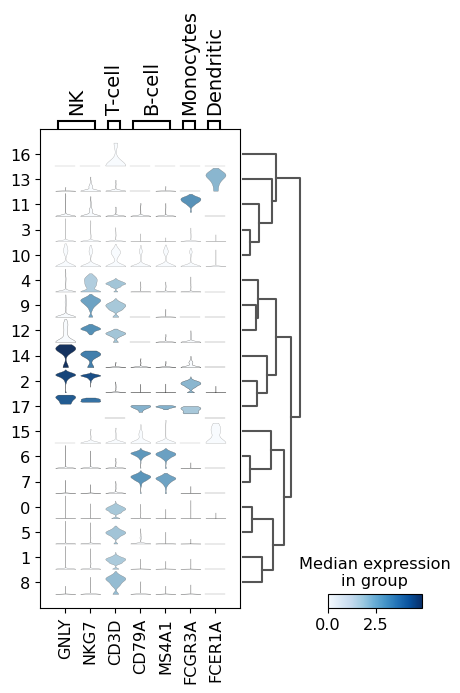

In [65]:
ax = sc.pl.stacked_violin(adata, marker_genes_dict, groupby='leiden', swap_axes=False, dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


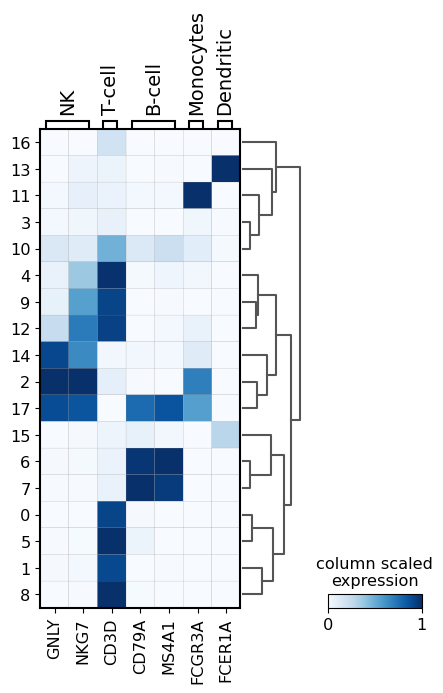

In [66]:
sc.pl.matrixplot(adata, marker_genes_dict, 'leiden', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

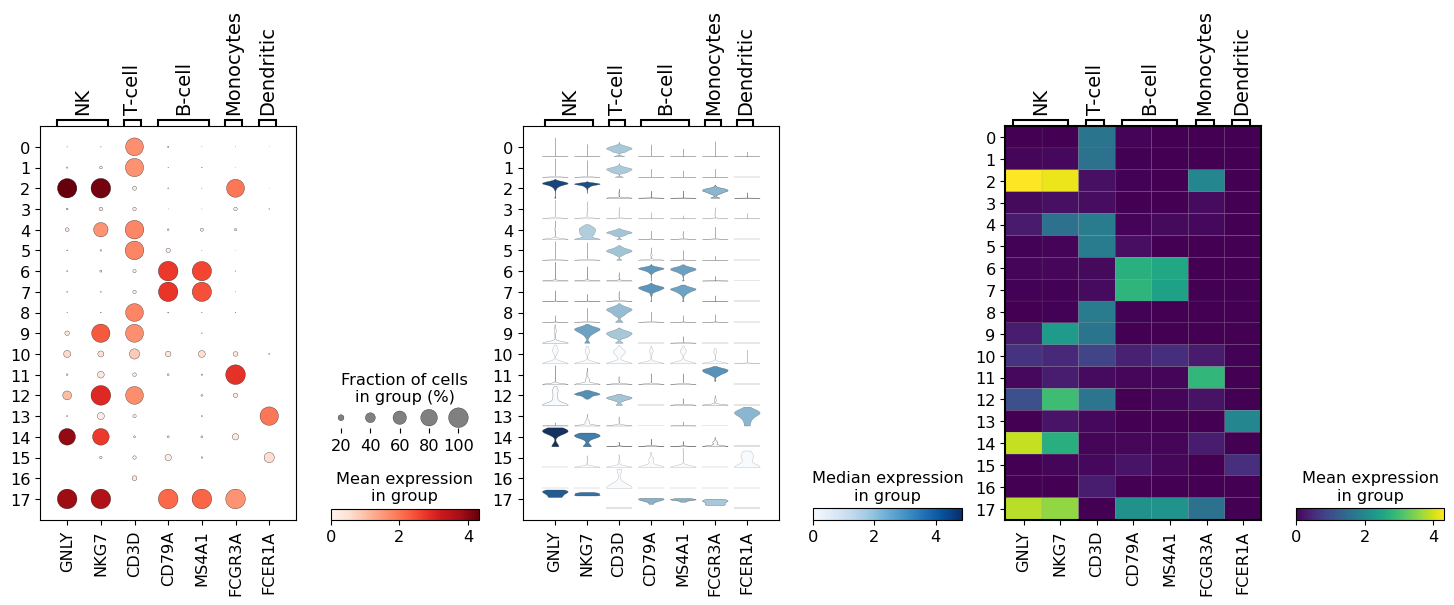

In [72]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6), gridspec_kw={'wspace':0.1})
ax1_dict = sc.pl.dotplot(adata, marker_genes_dict, groupby='leiden', ax=ax1, show=False)
ax2_dict = sc.pl.stacked_violin(adata, marker_genes_dict, groupby='leiden', ax=ax2, show=False)
ax3_dict = sc.pl.matrixplot(adata, marker_genes_dict, groupby='leiden', ax=ax3, show=False, cmap='viridis')

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


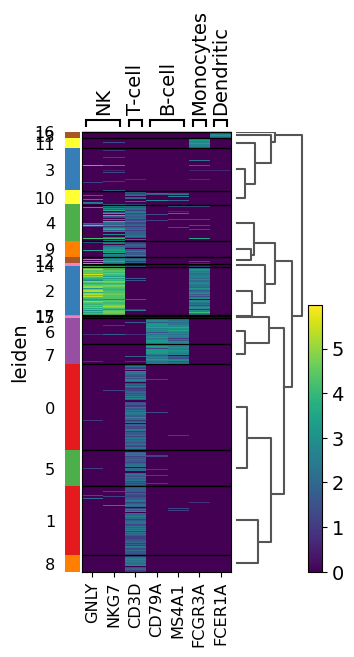

In [73]:
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='leiden', cmap='viridis', dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


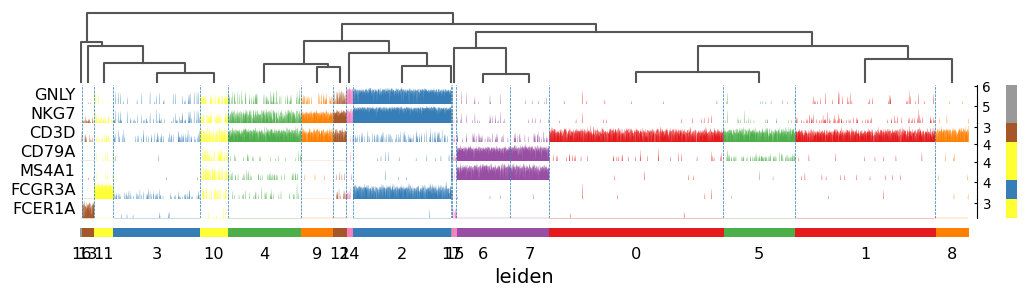

In [75]:
ax = sc.pl.tracksplot(adata,marker_genes_dict, groupby='leiden', dendrogram=True)

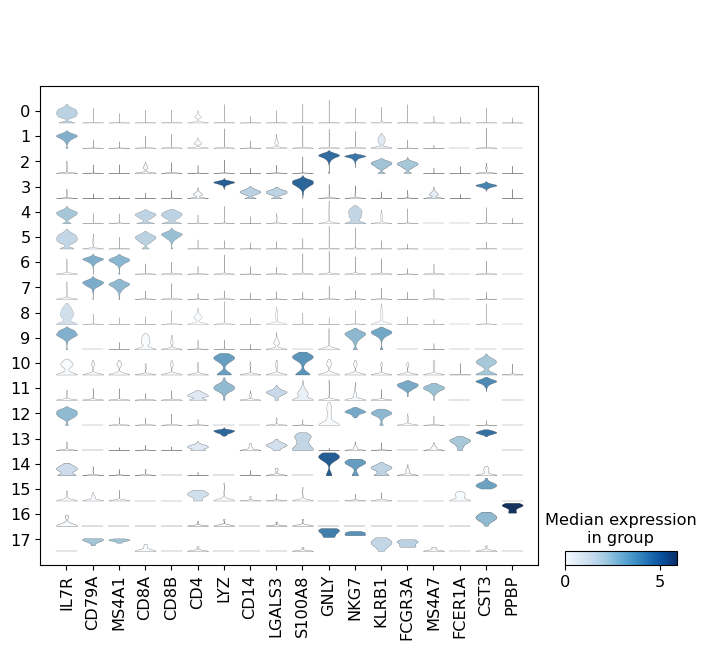

In [52]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

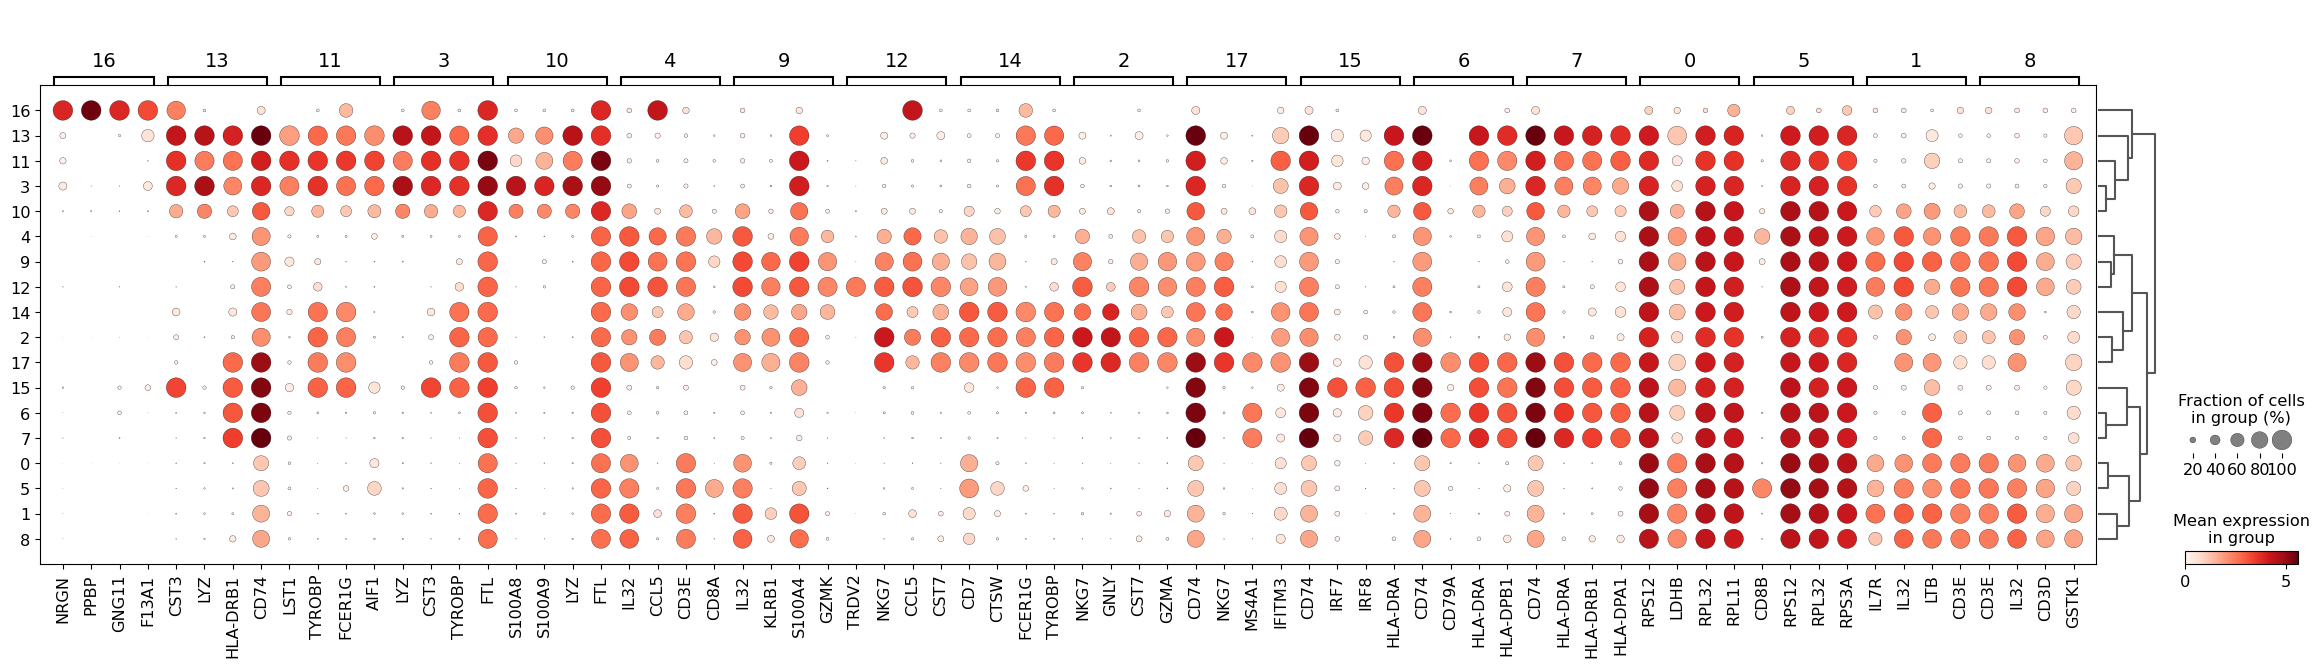

In [76]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4)

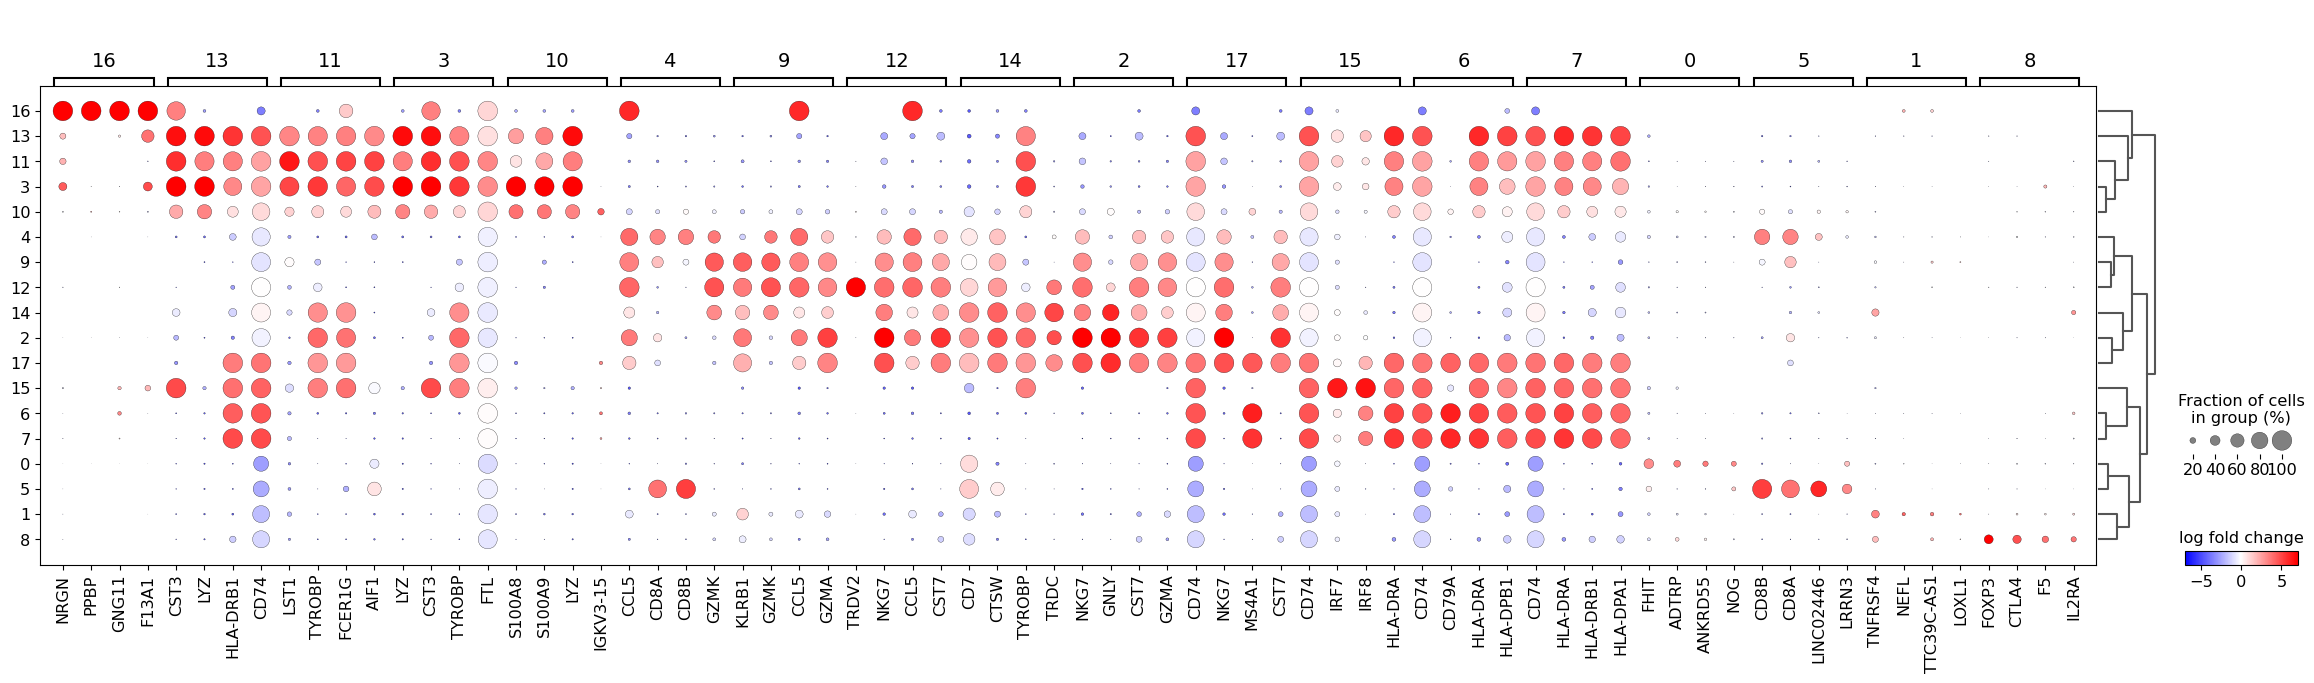

In [77]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

categories: 0, 1, 2, etc.
var_group_labels: 6


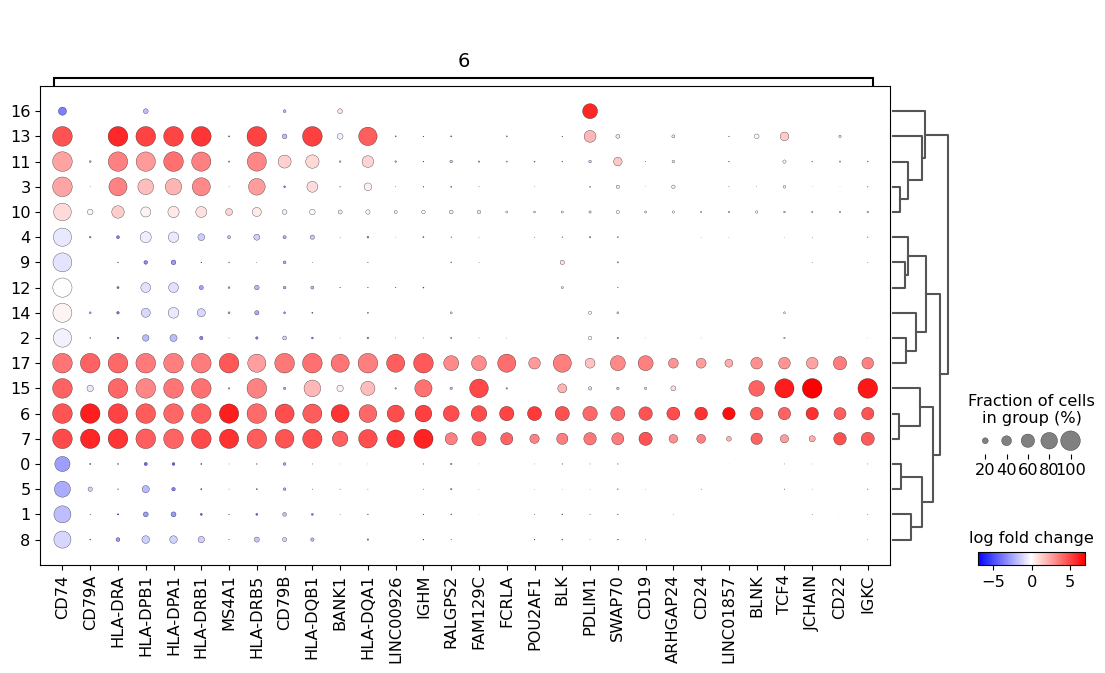

In [82]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=30, values_to_plot='logfoldchanges', min_logfoldchange=4, vmax=7, vmin=-7, cmap='bwr', groups=['6'])